In [51]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import requests
import pandas_datareader.data as web
from datetime import datetime
from pandas_datareader import DataReader, wb
from pandas_datareader.famafrench import get_available_datasets
from cycler import cycler

color_list = ["#348ABD","#A60628","#7A68A6","#467821","#CF4457","#188487","#E24A33"]
style = {
  "lines.linewidth": 2.0,
  "axes.edgecolor": "#bcbcbc",
  "patch.linewidth": 0.5,
  "legend.fancybox": True,
  "axes.prop_cycle": cycler('color', color_list),
  "axes.facecolor": "#ffffff",
  "axes.labelsize": "large",
  "axes.grid": True,
  "patch.edgecolor": "#eeeeee",
  "axes.titlesize": "x-large",
  "svg.fonttype": "path"}

matplotlib.rcParams.update(style)

In [26]:
def yahoo(symbol, start_date, end_date):
    data = DataReader(symbol, 'yahoo', start_date, end_date)
    data = data.reset_index()
    data.columns = [string.lower() for string in data.columns]
    #data = data.set_index('date')
    return data


def alphavantage(symbol, endpoint, start_date, end_date, API_key='6CW00BRWT0A7FTMF'):
    """
    Alpha Vantage provides realtime equities and forex data. 
    Through the Alpha Vantage Time Series endpoints, it is possible to obtain 
    historical equities and currency rate data for individual symbols. 
    For daily, weekly, and monthly frequencies, 20+ years of historical data 
    is available. The past 3-5 days of intraday data is also available.

    The following endpoints are available:

    av-intraday - Intraday Time Series
    av-daily - Daily Time Series
    av-daily-adjusted - Daily Time Series (Adjusted)
    av-weekly - Weekly Time Series
    av-weekly-adjusted - Weekly Time Series (Adjusted)
    av-monthly - Monthly Time Series
    av-monthly-adjusted - Monthly Time Series (Adjusted)
    av-forex-daily - Daily Time Series
    
    https://www.alphavantage.co/documentation/
    """
    data = DataReader(symbol, endpoint, start=start_date, end=end_date, api_key=API_key)
    return data

In [54]:
start_date = datetime(2000, 1, 1) 
end_date   = datetime(2022, 3, 18) 
freq = 'D' # W-Mon

#data = alphavantage("DJI", "av-daily", start_date, end_date)


sectors = {'Energy': '^SP500-1010',               # Oil&Gas Sector (^SP500-10) is not available 
           'Basic Materials': '^SP500-15',
           'Industrials'    : '^SP500-20',
           'Consumer Discretionary': '^SP500-25',
           'Consumer Staples': '^SP500-30',
           'Health Care': '^SP500-35',
           'Financials ': '^SP500-40',
           'Technology' : '^SP500-45',
           'Telecommunication ':'^SP500-50',
           'Utilities'  : '^SP500-55',
           'Real Estate': '^SP500-60'}


for i, key in enumerate(sectors.keys()):
    temp_df = yahoo(sectors[key], start_date, end_date)
    temp_df['Sector'] = key
    if i == 0: 
        data = temp_df
    else:
        data = pd.concat([data, temp_df], axis=0)
        
        
data.date = pd.to_datetime(data.date)
data = data.set_index('date')
data.to_csv(f'./Data/sector_performance_{datetime.now().strftime("%Hh%Mm%Ss")}.csv', encoding='utf-8')

In [55]:
data = pd.read_csv('./Data/sector_performance_21h04m46s.csv', encoding='utf-8', index_col=0)

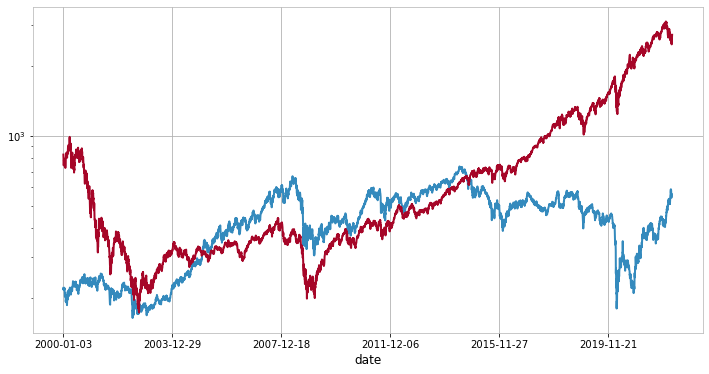

In [57]:
fig, ax = plt.subplots(figsize=(12,6))

data.loc[data.Sector == 'Energy'].close.plot(ax=ax)
data.loc[data.Sector == 'Technology'].close.plot(ax=ax)
plt.yscale('log')
plt.show()

In [98]:
table = pd.pivot(data[['close', 'Sector']].reset_index(),  
                 index='date', 
                 values='close',
                 columns='Sector').pct_change()

table.index = pd.DatetimeIndex(table.index)

In [99]:
table_resampled = (table+1).resample('M', label='right', closed='right').prod() - 1

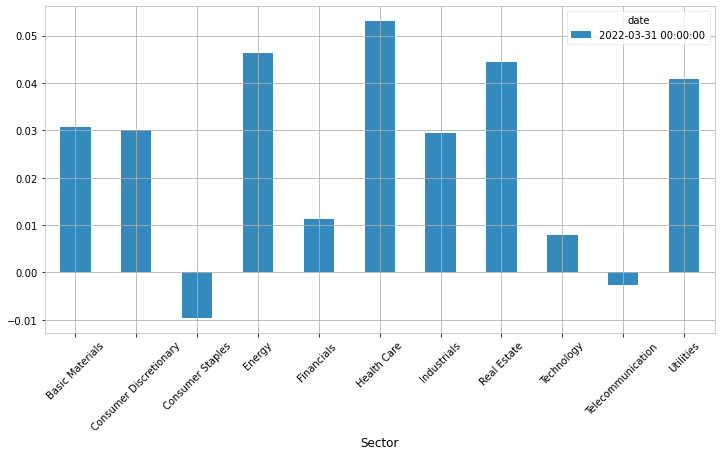

In [100]:
fig, ax = plt.subplots(figsize=(12,6))

table_resampled.iloc[-1:].T.plot.bar(ax=ax)
plt.xticks(rotation=45)
plt.show()